In [1]:
import pandas as pd
import yaml
import sys
import os
from glob import glob
from pathlib import Path
import gc
import pickle

import warnings
warnings.filterwarnings('ignore')

sys.path.append('/kaggle/src')
from utils.xgb import fit_xgb
from utils.metric import compute_comptetition_metric
from utils.set_seed import seed_base
from feature_engineering.fe_xgb import generate_features

MODEL_NAME = "xgb_model"
PACKAGE_DIR = Path("/kaggle/src")
CFG = yaml.safe_load(open(PACKAGE_DIR / "config.yaml", "r"))
print(CFG[MODEL_NAME]["execution"]["exp_id"])

CFG["output_dir"] = f"/kaggle/output/{CFG[MODEL_NAME]['execution']['exp_id']}"
!rm -r {CFG["output_dir"]}
os.makedirs(CFG["output_dir"], exist_ok=True)

seed_base(CFG["env"]["seed"])

2023-11-05 14:53:02.455630: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-05 14:53:02.523297: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-11-05 14:53:02.965970: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda/lib64:/usr/local/cuda/lib:/usr/local/lib/x86_64-linux-gnu:/usr/local/nvidia/lib:/u

exp_116


In [2]:
# 特徴生成
files = glob(f"{CFG['dataset']['step_csv_dir']}/*.parquet")
train, features = generate_features(files)

# cv splitとマージ
cv_split = pd.read_csv(CFG['dataset']['cv_split_path'])
train["fold"] = train["series_id"].map(cv_split.set_index("series_id")["fold"])
display(train.head(5))
train.shape

generate features: 100%|██████████| 277/277 [04:21<00:00,  1.06it/s]


,anglez,anglez_diff_abs,anglez_diff_abs_clip5,anglez_mean,enmo,enmo_diff_abs,enmo_mean,minutes,same_count,total_seconds,...,enmo_rolling_median_100_shift_1000,anglez_diff_abs_clip5_rolling_median_100_shift_1000,enmo_std_rolling_median_100_shift_1000,anglez_diff_abs_clip5_std_rolling_median_100_shift_1000,enmo_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_rolling_square_mean_100_shift_1000,enmo_std_rolling_square_mean_100_shift_1000,anglez_diff_abs_clip5_std_rolling_square_mean_100_shift_1000,reduce_step,fold
0,-86.521141,0.484678,0.484678,-11.018268,0.028438,0.001370,0.049629,957.5,0.0,44157.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,11,3
1,-87.261871,0.062595,0.062595,-10.602463,0.028079,0.000292,0.032782,1077.5,0.0,44277.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,35,3
18,-89.950226,0.048220,0.048220,-5.167186,0.028175,0.000229,0.047287,3117.5,0.0,46317.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,443,3
19,-89.891479,0.075483,0.075483,-4.354149,0.028121,0.000196,0.030720,3237.5,0.0,46437.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,467,3
20,-90.000000,0.000000,0.000000,-5.594111,0.028292,0.000242,0.024401,3357.5,0.0,46557.5,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,491,3


(537520, 1307)

In [3]:
# 学習
dfs = []
for event in ["wakeup", "onset"]:
    trn_oof, models = fit_xgb(
        X=train, 
        y=train[f"{event}_target"], 
        folds=train["fold"].astype(int), 
        features=features.all_features(),
        params=CFG[MODEL_NAME]["xgboost"], 
        es_rounds=200,
    )
    train["score"] = trn_oof
    train["event"] = event
    dfs.append(train[["series_id", "step", "score", "event"]])

    # 保存
    for i, model in enumerate(models):
        model.save_model(os.path.join(CFG["output_dir"], f'xgb_{event}_fold_{i}.model'))
del train
gc.collect()
train = pd.concat(dfs, axis=0)
train["step"] = train["step"].astype(int)
train = train.sort_values(["series_id", "step"]).reset_index(drop=True)


with open(os.path.join(CFG["output_dir"], "features.pkl"), "wb") as f:
    pickle.dump(features, f)
train.to_csv(os.path.join(CFG["output_dir"], "oof.csv"), index=False)

  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.59480
[100]	eval-rmse:1.18449
[200]	eval-rmse:1.07363
[300]	eval-rmse:1.04068
[400]	eval-rmse:1.02866
[500]	eval-rmse:1.02412
[600]	eval-rmse:1.02201
[700]	eval-rmse:1.02080
[800]	eval-rmse:1.01965
[900]	eval-rmse:1.01872
[1000]	eval-rmse:1.01794
[1100]	eval-rmse:1.01738
[1200]	eval-rmse:1.01683
[1300]	eval-rmse:1.01658
[1400]	eval-rmse:1.01621
[1500]	eval-rmse:1.01592
[1600]	eval-rmse:1.01554
[1700]	eval-rmse:1.01544
[1800]	eval-rmse:1.01542
[1900]	eval-rmse:1.01526
[2000]	eval-rmse:1.01510
[2100]	eval-rmse:1.01497
[2200]	eval-rmse:1.01488
[2300]	eval-rmse:1.01473
[2400]	eval-rmse:1.01469
[2500]	eval-rmse:1.01460
[2600]	eval-rmse:1.01460
[2650]	eval-rmse:1.01472


 20%|██        | 1/5 [01:50<07:23, 110.99s/it]

== fold 1 ==
[0]	eval-rmse:1.42558
[100]	eval-rmse:1.07449
[200]	eval-rmse:0.98590
[300]	eval-rmse:0.95858
[400]	eval-rmse:0.94707
[500]	eval-rmse:0.94159
[600]	eval-rmse:0.93919
[700]	eval-rmse:0.93750
[800]	eval-rmse:0.93657
[900]	eval-rmse:0.93577
[1000]	eval-rmse:0.93506
[1100]	eval-rmse:0.93427
[1200]	eval-rmse:0.93344
[1300]	eval-rmse:0.93292
[1400]	eval-rmse:0.93240
[1500]	eval-rmse:0.93185
[1600]	eval-rmse:0.93141
[1700]	eval-rmse:0.93099
[1800]	eval-rmse:0.93067
[1900]	eval-rmse:0.93034
[2000]	eval-rmse:0.93004
[2100]	eval-rmse:0.92982
[2200]	eval-rmse:0.92958
[2300]	eval-rmse:0.92947
[2400]	eval-rmse:0.92934
[2500]	eval-rmse:0.92909
[2600]	eval-rmse:0.92895
[2700]	eval-rmse:0.92877
[2800]	eval-rmse:0.92869
[2900]	eval-rmse:0.92843
[3000]	eval-rmse:0.92830
[3100]	eval-rmse:0.92819
[3200]	eval-rmse:0.92808
[3300]	eval-rmse:0.92807
[3400]	eval-rmse:0.92807
[3500]	eval-rmse:0.92790
[3600]	eval-rmse:0.92798
[3700]	eval-rmse:0.92798
[3739]	eval-rmse:0.92799


 40%|████      | 2/5 [04:12<06:26, 128.92s/it]

== fold 2 ==
[0]	eval-rmse:1.42290
[100]	eval-rmse:1.08524
[200]	eval-rmse:0.99690
[300]	eval-rmse:0.96967
[400]	eval-rmse:0.95917
[500]	eval-rmse:0.95447
[600]	eval-rmse:0.95210
[700]	eval-rmse:0.95052
[800]	eval-rmse:0.94962
[900]	eval-rmse:0.94900
[1000]	eval-rmse:0.94847
[1100]	eval-rmse:0.94804
[1200]	eval-rmse:0.94765
[1300]	eval-rmse:0.94726
[1400]	eval-rmse:0.94694
[1500]	eval-rmse:0.94672
[1600]	eval-rmse:0.94640
[1700]	eval-rmse:0.94633
[1800]	eval-rmse:0.94626
[1900]	eval-rmse:0.94608
[2000]	eval-rmse:0.94588
[2100]	eval-rmse:0.94570
[2200]	eval-rmse:0.94544
[2300]	eval-rmse:0.94537
[2400]	eval-rmse:0.94527
[2500]	eval-rmse:0.94524
[2600]	eval-rmse:0.94512
[2700]	eval-rmse:0.94523
[2800]	eval-rmse:0.94530
[2802]	eval-rmse:0.94529


 60%|██████    | 3/5 [05:59<03:58, 119.08s/it]

== fold 3 ==
[0]	eval-rmse:1.54770
[100]	eval-rmse:1.15370
[200]	eval-rmse:1.04928
[300]	eval-rmse:1.02022
[400]	eval-rmse:1.01033
[500]	eval-rmse:1.00602
[600]	eval-rmse:1.00351
[700]	eval-rmse:1.00226
[800]	eval-rmse:1.00141
[900]	eval-rmse:1.00088
[1000]	eval-rmse:1.00039
[1100]	eval-rmse:1.00008
[1200]	eval-rmse:0.99978
[1300]	eval-rmse:0.99964
[1400]	eval-rmse:0.99963
[1500]	eval-rmse:0.99960
[1600]	eval-rmse:0.99980
[1643]	eval-rmse:0.99977


 80%|████████  | 4/5 [07:10<01:39, 99.89s/it] 

== fold 4 ==
[0]	eval-rmse:1.44215
[100]	eval-rmse:1.08645
[200]	eval-rmse:0.99379
[300]	eval-rmse:0.96629
[400]	eval-rmse:0.95709
[500]	eval-rmse:0.95340
[600]	eval-rmse:0.95142
[700]	eval-rmse:0.95034
[800]	eval-rmse:0.94970
[900]	eval-rmse:0.94917
[1000]	eval-rmse:0.94889
[1100]	eval-rmse:0.94867
[1200]	eval-rmse:0.94842
[1300]	eval-rmse:0.94828
[1400]	eval-rmse:0.94809
[1500]	eval-rmse:0.94787
[1600]	eval-rmse:0.94768
[1700]	eval-rmse:0.94749
[1800]	eval-rmse:0.94728
[1900]	eval-rmse:0.94711
[2000]	eval-rmse:0.94691
[2100]	eval-rmse:0.94684
[2200]	eval-rmse:0.94669
[2300]	eval-rmse:0.94675
[2396]	eval-rmse:0.94678


  0%|          | 0/5 [00:00<?, ?it/s]

== fold 0 ==
[0]	eval-rmse:1.60124
[100]	eval-rmse:1.18389
[200]	eval-rmse:1.07224
[300]	eval-rmse:1.04070
[400]	eval-rmse:1.02975
[500]	eval-rmse:1.02511
[600]	eval-rmse:1.02286
[700]	eval-rmse:1.02200
[800]	eval-rmse:1.02113
[900]	eval-rmse:1.02066
[1000]	eval-rmse:1.02029
[1100]	eval-rmse:1.02007
[1200]	eval-rmse:1.01993
[1300]	eval-rmse:1.01990
[1400]	eval-rmse:1.01964
[1500]	eval-rmse:1.01960
[1600]	eval-rmse:1.01951
[1700]	eval-rmse:1.01948
[1800]	eval-rmse:1.01943
[1900]	eval-rmse:1.01941
[2000]	eval-rmse:1.01935
[2100]	eval-rmse:1.01943
[2187]	eval-rmse:1.01941


 20%|██        | 1/5 [01:26<05:44, 86.23s/it]

== fold 1 ==
[0]	eval-rmse:1.42519
[100]	eval-rmse:1.04207
[200]	eval-rmse:0.93764
[300]	eval-rmse:0.90554
[400]	eval-rmse:0.89270
[500]	eval-rmse:0.88613
[600]	eval-rmse:0.88359
[700]	eval-rmse:0.88238
[800]	eval-rmse:0.88157
[900]	eval-rmse:0.88087
[1000]	eval-rmse:0.88036
[1100]	eval-rmse:0.88018
[1200]	eval-rmse:0.87996
[1300]	eval-rmse:0.87955
[1400]	eval-rmse:0.87925
[1500]	eval-rmse:0.87903
[1600]	eval-rmse:0.87888
[1700]	eval-rmse:0.87880
[1800]	eval-rmse:0.87871
[1900]	eval-rmse:0.87863
[2000]	eval-rmse:0.87856
[2100]	eval-rmse:0.87857
[2200]	eval-rmse:0.87863
[2247]	eval-rmse:0.87865


 40%|████      | 2/5 [02:54<04:22, 87.65s/it]

== fold 2 ==
[0]	eval-rmse:1.42033
[100]	eval-rmse:1.07193
[200]	eval-rmse:0.97869
[300]	eval-rmse:0.94947
[400]	eval-rmse:0.93885
[500]	eval-rmse:0.93405
[600]	eval-rmse:0.93120
[700]	eval-rmse:0.92976
[800]	eval-rmse:0.92884
[900]	eval-rmse:0.92795
[1000]	eval-rmse:0.92727
[1100]	eval-rmse:0.92701
[1200]	eval-rmse:0.92669
[1300]	eval-rmse:0.92653
[1400]	eval-rmse:0.92646
[1500]	eval-rmse:0.92636
[1600]	eval-rmse:0.92632
[1700]	eval-rmse:0.92618
[1800]	eval-rmse:0.92612
[1900]	eval-rmse:0.92600
[2000]	eval-rmse:0.92593
[2100]	eval-rmse:0.92592
[2200]	eval-rmse:0.92574
[2300]	eval-rmse:0.92574
[2400]	eval-rmse:0.92585
[2500]	eval-rmse:0.92567
[2600]	eval-rmse:0.92570
[2700]	eval-rmse:0.92563
[2800]	eval-rmse:0.92557
[2900]	eval-rmse:0.92556
[3000]	eval-rmse:0.92556
[3100]	eval-rmse:0.92566
[3167]	eval-rmse:0.92568


 60%|██████    | 3/5 [04:53<03:23, 101.63s/it]

== fold 3 ==
[0]	eval-rmse:1.54295
[100]	eval-rmse:1.16274
[200]	eval-rmse:1.07195
[300]	eval-rmse:1.04908
[400]	eval-rmse:1.04121
[500]	eval-rmse:1.03772
[600]	eval-rmse:1.03633
[700]	eval-rmse:1.03557
[800]	eval-rmse:1.03523
[900]	eval-rmse:1.03488
[1000]	eval-rmse:1.03490
[1100]	eval-rmse:1.03482
[1200]	eval-rmse:1.03486
[1251]	eval-rmse:1.03485


 80%|████████  | 4/5 [05:47<01:22, 82.77s/it] 

== fold 4 ==
[0]	eval-rmse:1.43841
[100]	eval-rmse:1.08183
[200]	eval-rmse:0.99571
[300]	eval-rmse:0.97295
[400]	eval-rmse:0.96572
[500]	eval-rmse:0.96205
[600]	eval-rmse:0.95992
[700]	eval-rmse:0.95898
[800]	eval-rmse:0.95808
[900]	eval-rmse:0.95756
[1000]	eval-rmse:0.95714
[1100]	eval-rmse:0.95677
[1200]	eval-rmse:0.95647
[1300]	eval-rmse:0.95613
[1400]	eval-rmse:0.95583
[1500]	eval-rmse:0.95559
[1600]	eval-rmse:0.95533
[1700]	eval-rmse:0.95497
[1800]	eval-rmse:0.95479
[1900]	eval-rmse:0.95472
[2000]	eval-rmse:0.95457
[2100]	eval-rmse:0.95457
[2200]	eval-rmse:0.95438
[2300]	eval-rmse:0.95432
[2400]	eval-rmse:0.95424
[2500]	eval-rmse:0.95410
[2600]	eval-rmse:0.95408
[2700]	eval-rmse:0.95398
[2800]	eval-rmse:0.95393
[2900]	eval-rmse:0.95392
[3000]	eval-rmse:0.95394
[3100]	eval-rmse:0.95397
[3135]	eval-rmse:0.95399


100%|██████████| 5/5 [07:43<00:00, 92.64s/it]


## Dynamic-Range NMS

<AxesSubplot: >

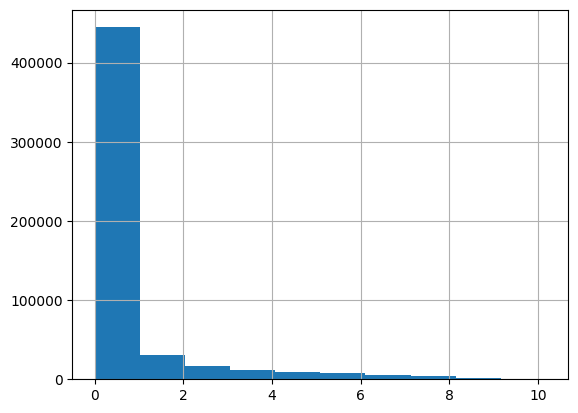

In [4]:
train = train[train["score"] > 0.005]
train["score"].hist()

In [5]:
from utils.postprocess import dynamic_range_nms
from multiprocessing import Pool
from tqdm import tqdm

train["step"] = train["step"].astype(int)

groups = [group for _, group in train.groupby("series_id")]
with Pool(30) as p:  
    results = list(tqdm(p.imap(dynamic_range_nms, groups), total=len(groups)))
sub = pd.concat(results)
sub["score"] = sub["reduced_score"]

100%|██████████| 277/277 [00:07<00:00, 37.16it/s]


In [6]:
# スコア計算
labels = pd.read_csv(f"{CFG['dataset']['competition_dir']}/train_events.csv").dropna()
score, ap_table = compute_comptetition_metric(labels, sub)

print(f"score: {score:.4f}")
display(ap_table)
sub.to_csv(os.path.join(CFG["output_dir"], "submission_after_nms.csv"), index=False)

score: 0.7742


event   tolerance
onset   12           0.260540
        36           0.668111
        60           0.767135
        90           0.812435
        120          0.834705
        150          0.851091
        180          0.862080
        240          0.877687
        300          0.884532
        360          0.889889
wakeup  12           0.219216
        36           0.689269
        60           0.774846
        90           0.818201
        120          0.842282
        150          0.860085
        180          0.871771
        240          0.889322
        300          0.899936
        360          0.910303
dtype: float64